# Phase shift and TE

Aim: Investigate whether a phase shift in the data generated from a harmonic function would affect the TE.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append('../core/')
from te import bi_te
from entropy import entropy
from pseudoTE import pTE

$$
x_i = 0.5 x_{i-1} - 0.3x_{i-5} +0.1y_{i-2}+0.1 x_{i-2}^2 + 0.4 y_{i-1}y_{i-2} + \varepsilon_{x,i}
$$

$$
y_i = \sin(6\pi t+\varphi) + \varepsilon_{y,i}
$$

By Construction:
* The maximum TE is expected at lag 5 (observe $x_{i-5}$).
* The TE $x\to y $ should be negligible. 

In [2]:
def sampleGen(n,phaseShift=0):
    """
    M10 model from Selini & Masollor 2021
    """
    x = np.zeros((int(2*n),2))    
    t = np.linspace(0.,10.,int(2*n))
    #for j in range(2):
    #    x[j,0]=np.random.rand(2)  #initial data for x1 
           
    np.random.seed(1000)
    rho_eps=0.7  #correlation between the noises
    sdev1 = .2
    sdev2 = .2
    covMat_eps = np.asarray([[sdev1**2,rho_eps*sdev1*sdev2],[rho_eps*sdev1*sdev2,sdev2**2]])
    eps = np.random.multivariate_normal(np.zeros(2), covMat_eps, 2*n).T
    
    #sample generator
    for i in range(2,2*n):
        x[i,0] = 0.5*x[i-1,0] - 0.3*x[i-5,0] +0.1*x[i-2,1] +0.1*x[i-2,0]**2. + 0.4*x[i-1,1]*x[i-2,1] + eps[0,i]
        x[i,1] = np.sin(6.*np.pi*t[i]+phaseShift) + eps[1,i]
        
    return x[n:,:]
    

## Generate data

Set the value of $\varphi$, the phase shift and generate samples:

In [3]:
phaseShift_ = 0.0*np.pi   #phase shift value

x = sampleGen(n=1000,phaseShift=phaseShift_)
n = x.shape[0]

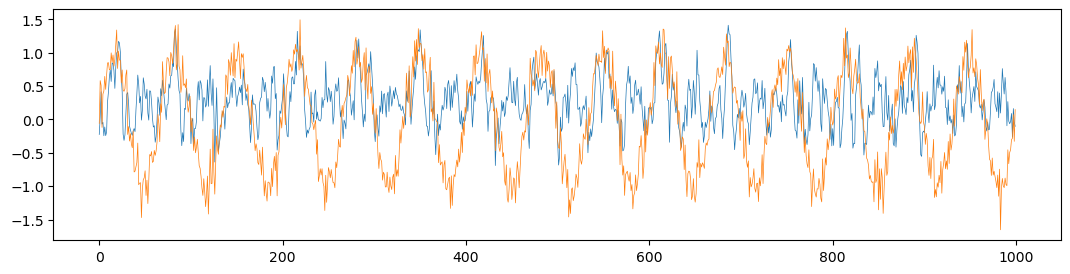

In [4]:
plt.figure(figsize=(13,3))
plt.plot(np.arange(n),x[:,0],lw=0.5)
plt.plot(np.arange(n),x[:,1],lw=0.5)
plt.show()

## Calculate TE

In [5]:
x_ = x[:,0]
y_ = x[:,1]

lagList=[1,2,3,4,5,7,9,11,15,20,30]   #lags at which TE will be estimated

Pseudo TE ( we know these can be accurate only for linear VAR with Gaussian noise -- and hence not for the time series we have here):

In [6]:
pte_xy=[]
pte_yx=[]

for lag in lagList:
    pte_, ptesurr_ = pTE(x.T, tau=1, dimEmb=lag, surr=None, Nsurr=19)
    pte_xy.append(pte_[0,1])
    pte_yx.append(pte_[1,0])
pte_xy = np.array(pte_xy)    
pte_yx = np.array(pte_yx)    

../core/pseudoTE.py:165: RuntimeWarning: invalid value encountered in double_scalars
  np.linalg.det(np.cov(YYtXt.T)) * np.linalg.det(np.cov(Ytau.T)))


USE KSG estimator for computing the TE between $x$ and $y$:

In [7]:
te_ksg_xy=[]
te_ksg_yx=[]

for lag in lagList:      
    te1_ = bi_te(x_, y_, embDim=lag).ksg(k=10)
    te_ksg_xy.append(te1_)
    
    te2_ = bi_te(y_, x_, embDim=lag).ksg(k=10)
    te_ksg_yx.append(te2_)
    
te_ksg_xy = np.array(te_ksg_xy)    
te_ksg_yx = np.array(te_ksg_yx)

Plots

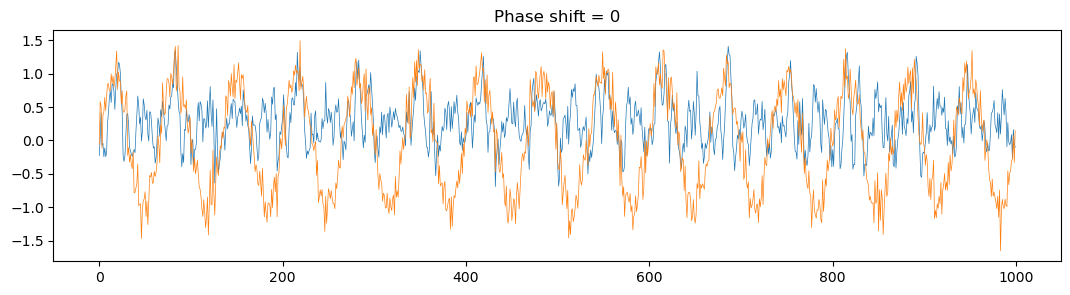

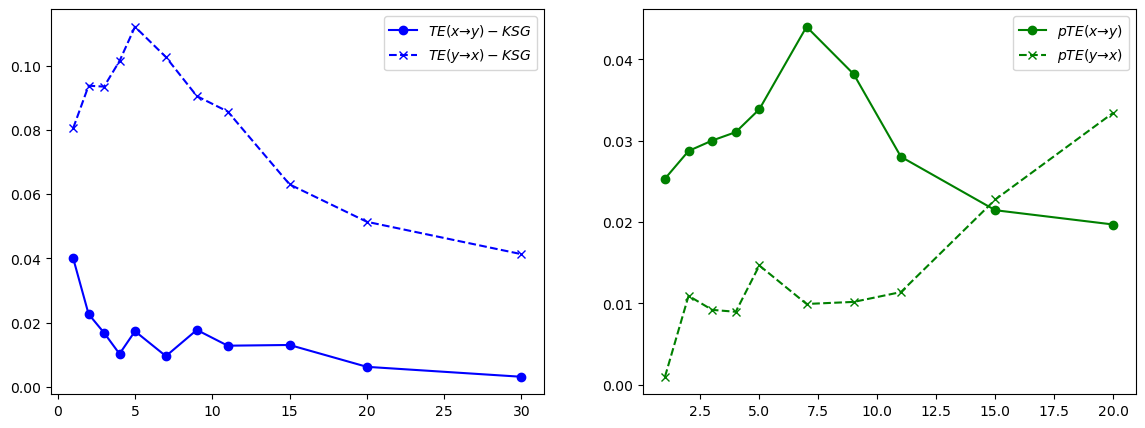

In [8]:
plt.figure(figsize=(13,3))
plt.title("Phase shift = %g" %phaseShift_)
plt.plot(np.arange(n),x[:,0],lw=0.5)
plt.plot(np.arange(n),x[:,1],lw=0.5)


plt.figure(figsize=(14,5))

plt.subplot(121)
plt.plot(lagList,te_ksg_xy,'-ob',label=r'$TE(x\to y) - KSG$')    
plt.plot(lagList,te_ksg_yx,'--xb',label=r'$TE(y\to x) - KSG$')    
plt.legend(loc='best')

plt.subplot(122)

plt.plot(lagList,pte_xy,'-og',label=r'$pTE(x\to y) $')    
plt.plot(lagList,pte_yx,'--xg',label=r'$pTE(y\to x) $')    

plt.legend(loc='best')
plt.show()

### Conclusions: 
* The max TE is slightly affected by the phase shift
* But the lag at which max TE happens (lag =5) remains unchanged